# Feature Extraction

In [17]:
#image_stats
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import shannon_entropy
from tqdm import tqdm

# Set path to training image folder
TRAIN_DIR = "../train"  
TEST_DIR = "../test"

def extract_stats_from_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    features = {}
    for i, channel in enumerate(['R', 'G', 'B']):
        c_data = img_rgb[:, :, i]
        features[f'{channel}_mean'] = np.mean(c_data)
        features[f'{channel}_std'] = np.std(c_data)
        features[f'{channel}_min'] = np.min(c_data)
        features[f'{channel}_max'] = np.max(c_data)
        features[f'{channel}_entropy'] = shannon_entropy(c_data)
    
    features['image_entropy'] = shannon_entropy(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    features['image_height'] = img.shape[0]
    features['image_width'] = img.shape[1]
    return features

def build_feature_df(metadata_csv, image_dir):
    df = pd.read_csv(metadata_csv)
    feature_list = []
    
    print("Extracting image stats...")
    for path in tqdm(df['image_path']):
        full_path = os.path.join(image_dir, path)
        stats = extract_stats_from_image(full_path)
        stats['Path'] = path
        feature_list.append(stats)

    return pd.DataFrame(feature_list)

# Example usage
train_features_df = build_feature_df("../2025_A2/train/train_metadata.csv", "../2025_A2/train")
test_features_df = build_feature_df("../2025_A2/test/test_metadata.csv", "../2025_A2/test")

# Save to CSV (optional)
train_features_df.to_csv("../2025_A2/train/train_image_stats.csv", index=False)
test_features_df.to_csv("../2025_A2/test/test_image_stats.csv", index=False)


Extracting image stats...


100%|██████████| 5488/5488 [00:02<00:00, 1904.55it/s]


Extracting image stats...


100%|██████████| 2353/2353 [00:01<00:00, 2057.20it/s]


# Merge all csvs

In [18]:
import pandas as pd
from functools import reduce

# Paths to your CSVs
feature_files_train = [
    "../2025_A2/train/train_image_stats.csv",
    "../2025_A2/train/Features/color_histogram.csv",
    "../2025_A2/train/Features/hog_pca.csv",
    "../2025_A2/train/Features/additional_features.csv",
]

feature_files_test = [
    "../2025_A2/test/test_image_stats.csv",
    "../2025_A2/test/Features/color_histogram.csv",
    "../2025_A2/test/Features/hog_pca.csv",
    "../2025_A2/test/Features/additional_features.csv",
]

# Load train metadata for labels
train_labels = pd.read_csv("../2025_A2/train/train_metadata.csv")[["image_path", "ClassId"]]

# Merge all feature CSVs on "image_path" (rename if needed)
def load_and_prepare(files, is_train=True):
    dfs = []
    for path in files:
        df = pd.read_csv(path)
        # Ensure consistent column for join
        if "Path" in df.columns:
            df.rename(columns={"Path": "image_path"}, inplace=True)
        dfs.append(df)
    merged = reduce(lambda left, right: pd.merge(left, right, on="image_path"), dfs)
    if is_train:
        merged = pd.merge(merged, train_labels, on="image_path")
    return merged

# Final merged DataFrames
train_df = load_and_prepare(feature_files_train, is_train=True)
test_df = load_and_prepare(feature_files_test, is_train=False)

# Save for future use
train_df.to_csv("../2025_A2/train/train_merged.csv", index=False)
test_df.to_csv("../2025_A2/test/test_merged.csv", index=False)

print("✅ Merged train and test feature sets.")
# Show a few rows from each
print("TRAIN DF:")
display(train_df.head())

print("TEST DF:")
display(test_df.head())


✅ Merged train and test feature sets.
TRAIN DF:


,R_mean,R_std,R_min,R_max,R_entropy,G_mean,G_std,G_min,G_max,G_entropy,...,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,edge_density,mean_b,mean_g,mean_r,ClassId
0,62.978125,36.990181,14,166,6.640146,62.227083,38.952274,15,165,6.609715,...,0.450825,-0.213796,-0.882416,-0.309656,0.271686,0.050293,63.748291,62.107910,62.850830,32
1,61.665219,34.981211,18,147,6.388761,52.992618,38.041404,17,156,5.727465,...,-0.335682,-0.886182,0.507969,0.006536,0.471807,0.034424,48.680664,52.872314,61.539307,13
2,127.405808,84.941762,6,255,7.227270,110.819859,69.495283,10,255,7.567161,...,0.501386,-0.421448,0.081289,0.730258,-0.205895,0.126709,99.174561,110.774658,127.348389,7
3,29.118153,17.854223,9,81,5.209524,26.722952,17.947492,11,84,5.018010,...,0.285638,-0.481589,-0.101580,-0.139084,0.586276,0.026123,30.493896,26.616211,29.006592,4
4,79.647059,41.986775,23,255,6.629295,97.831315,35.814136,60,250,6.027333,...,-0.520063,0.062209,0.248771,0.140214,0.292198,0.106934,116.836670,97.684814,79.495605,35


TEST DF:


,R_mean,R_std,R_min,R_max,R_entropy,G_mean,G_std,G_min,G_max,G_entropy,...,hog_pca_14,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,edge_density,mean_b,mean_g,mean_r
0,179.147720,67.068396,9,255,6.462796,185.063377,70.403587,7,255,5.851940,...,0.283365,-0.301160,-0.334299,0.138616,0.257037,0.684263,0.215820,185.704590,185.033691,179.084717
1,81.925040,37.520033,9,159,6.758047,69.555343,42.965719,13,159,6.771544,...,-0.229380,0.829642,0.137557,0.487105,-0.306732,-0.213233,0.174561,67.885010,69.434814,81.814453
2,56.389286,24.509175,14,168,6.345503,56.477381,22.726782,20,156,6.177935,...,0.337062,0.182572,-0.373714,0.262148,0.122967,-0.624942,0.068115,72.898193,56.364990,56.273926
3,59.513228,24.587143,34,149,5.876929,50.500000,21.458617,27,132,5.298757,...,0.528455,0.411835,-0.654511,0.084131,-0.269949,-0.186074,0.039551,47.619629,50.394043,59.411377
4,44.844291,31.418373,15,148,5.687445,39.654844,30.734341,17,147,5.314677,...,0.120786,-0.020706,0.609833,0.413756,-0.373302,0.257994,0.073242,46.095947,39.547852,44.725586


# Preprocessing

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop non-feature columns
X = train_df.drop(columns=["image_path", "ClassId"])
y = train_df["ClassId"]

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Also transform full train + test for final prediction later
X_full_scaled = scaler.fit_transform(X)  # for full training
X_test = test_df.drop(columns=["image_path"])
X_test_scaled = scaler.transform(X_test)


🎯 Validation Accuracy: 0.7914

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.68      0.82      0.74        62
           2       0.66      0.79      0.72        63
           3       0.72      0.59      0.65        39
           4       0.75      0.65      0.70        55
           5       0.71      0.71      0.71        52
           6       1.00      0.92      0.96        12
           7       0.71      0.75      0.73        40
           8       0.76      0.64      0.69        39
           9       0.82      0.76      0.78        41
          10       0.74      0.82      0.78        56
          11       0.51      0.70      0.59        37
          12       0.97      1.00      0.98        59
          13       1.00      1.00      1.00        60
          14       1.00      0.95      0.98        22
          15       1.00      0.78      0.88        18
          16       1.00 

/Users/himankbassi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/himankbassi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/himankbassi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


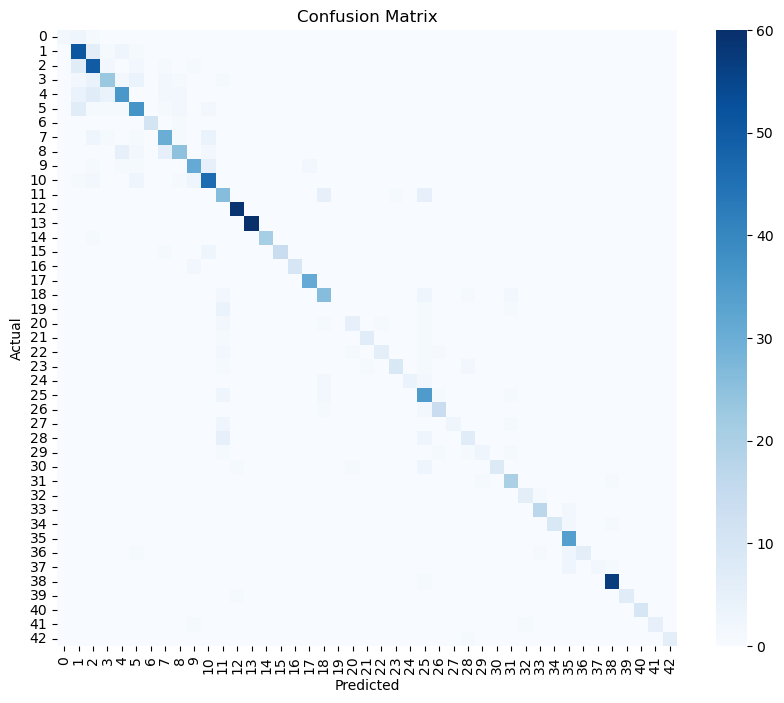

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred = rf.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_pred)
print(f"🎯 Validation Accuracy: {acc:.4f}\n")
print("📊 Classification Report:\n", classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [24]:
# STEP 1: Load the correct test metadata
test_meta = pd.read_csv("../2025_A2/test/test_metadata.csv")  # This file has 'id' and 'image_path'

# STEP 2: Make sure predictions line up by merging with image_path
submission = pd.DataFrame({
    "image_path": test_df["image_path"],   # From your test features
    "ClassId": test_preds                  # Model output
})

# STEP 3: Merge predictions with test metadata to get the right ID
submission = submission.merge(test_meta[["id", "image_path"]], on="image_path")

# STEP 4: Rename 'id' → 'Id' and drop image_path
submission = submission.rename(columns={"id": "Id"}).drop(columns=["image_path"])

# STEP 5: Save to CSV
submission.to_csv("submission.csv", index=False)

print("✅ Final submission.csv ready with correct Id and ClassId columns.")


✅ Final submission.csv ready with correct Id and ClassId columns.


In [25]:
import pandas as pd

# Load your incorrect submission
df = pd.read_csv("submission.csv", header=0)

# Rename the numeric-ID column (case-sensitive) and reorder
# Your current columns are ['ClassId','ID'] (or maybe ['ClassId','Id']); adjust below if needed
df = df.rename(columns={"ID": "Id"})  # if your column is 'ID'
# Or if it's lowercase 'id', do: df.rename(columns={"id":"Id"}, inplace=True)

# Now reorder so Id comes first
df = df[["Id", "ClassId"]]

# Save the corrected file
df.to_csv("submission_fixed.csv", index=False)
print("✅ Written submission_fixed.csv with correct header and order")

✅ Written submission_fixed.csv with correct header and order


Fitting 5 folds for each of 15 candidates, totalling 75 fits
🔍 Best k: 1
🎯 Validation Accuracy: 0.7869

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.84      0.79      0.82        62
           2       0.72      0.81      0.76        63
           3       0.59      0.67      0.63        39
           4       0.72      0.85      0.78        55
           5       0.64      0.81      0.71        52
           6       0.92      0.92      0.92        12
           7       0.81      0.85      0.83        40
           8       0.69      0.74      0.72        39
           9       0.83      0.73      0.78        41
          10       0.78      0.77      0.77        56
          11       0.62      0.62      0.62        37
          12       0.94      0.85      0.89        59
          13       0.93      0.87      0.90        60
          14       0.95      0.91      0.93        22
     

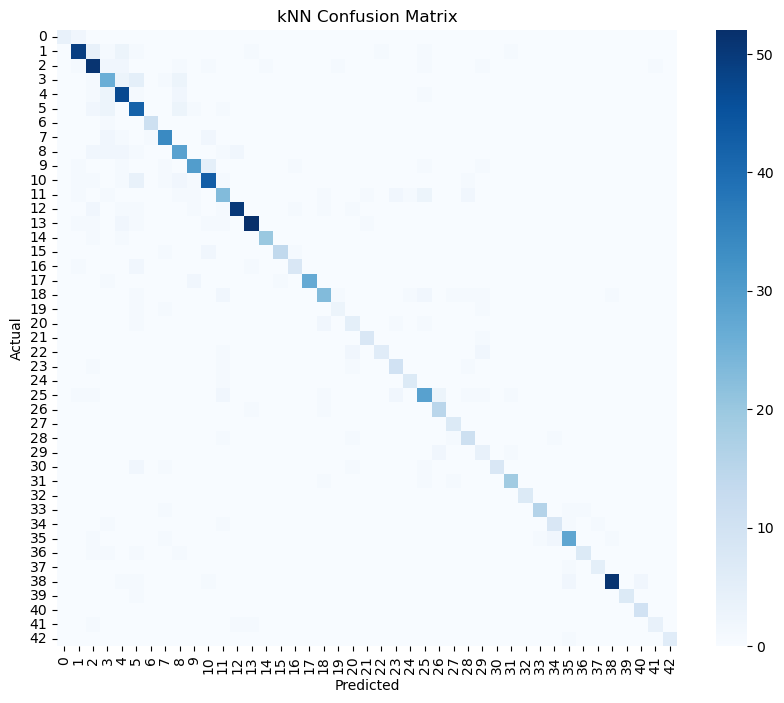

✅ Saved correct submission_knn.csv with columns: id,ClassId


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Tune k using GridSearch
param_grid = {'n_neighbors': list(range(1, 16))}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

best_knn = grid.best_estimator_
print(f"🔍 Best k: {grid.best_params_['n_neighbors']}")

# Step 2: Evaluate on validation set
y_pred = best_knn.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_pred)
print(f"🎯 Validation Accuracy: {val_acc:.4f}\n")
print("📊 Classification Report:\n", classification_report(y_val, y_pred))

# Step 3: Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("kNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 4: Predict on test set
test_preds_knn = best_knn.predict(X_test_scaled)


# Load test metadata
test_meta = pd.read_csv("../2025_A2/test/test_metadata.csv")  # contains 'id' and 'image_path'

# Match predictions to image paths
submission_knn = pd.DataFrame({
    "image_path": test_df["image_path"],
    "ClassId": test_preds_knn
})

# Merge to get 'id'
submission_knn = submission_knn.merge(test_meta[["id", "image_path"]], on="image_path")

# ✅ Reorder: id first, ClassId second
submission_knn = submission_knn[["id", "ClassId"]]

# Save it
submission_knn.to_csv("submission_knn.csv", index=False)

print("✅ Saved correct submission_knn.csv with columns: id,ClassId")

